In [1]:
import sys, os
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.morphology import skeletonize, remove_small_holes, remove_small_objects,\
                            binary_opening, disk
from skimage import filters
from skimage.feature import peak_local_max
from skimage.transform import resize

from scipy import interpolate
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt

from PyQt5 import QtCore, QtGui, QtWidgets

%matplotlib notebook

In [2]:
### useful functions

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # add or remove point
    if event.button == 1:
        output['endpoints'].append([ix,iy])
    elif event.button == 3:
        if len(output['endpoints'])>0:
            output['endpoints'].pop()
    # replot endpoints
    if len(output['endpoints'])==0:
        scatter.set_offsets(np.array([[np.nan,np.nan]]))
    else:
        scatter.set_offsets(np.array(output['endpoints']))
    
    # if only two endpoints, compute spline and width profile
    if len(output['endpoints'])==2:
        landmarks = order_points(output['endpoints'], cs)
        ps,ts,ns,arc_length = compute_spline(landmarks)
#         ax[0].title.set_text('ciao')#ps.shape)
        profile = compute_profile(ps, ts, ns)
#         ax[2].title.set_text('ciao')#ps.shape)
        
        # update output
        output['ps'] = ps
        output['ts'] = ts
        output['ns'] = ns
        output['arc_length'] = arc_length
        output['profile'] = profile

        # replot spline
        plot1.set_data(ps[:,1], ps[:,0])
#         quiver1.set_offsets(ps[::10,1], ps[::10,0])
#         quiver1.set_UVC(ns[::10,1], ns[::10,0])
        scatter1.set_offsets(np.array(output['endpoints']))
        
        # replot width
        plot2.set_data(arc_length, profile)
        ax[2].relim()
        ax[2].autoscale_view()
    
def order_points(endpoints, cs):
    ### order landmarks from first to last

    endpoints = np.array(endpoints)[:,::-1]
    landmarks = np.array([endpoints[0]])
    remaining_points = cs.copy()

    while len(remaining_points)>0:
        dists = [np.linalg.norm(landmarks[-1]-r) for r in remaining_points]
        idx = dists.index(np.min(dists))
        if np.min(dists)<1000:
            landmarks = np.insert(landmarks, len(landmarks), remaining_points[idx], 0)
        remaining_points = np.delete(remaining_points, idx, 0)

    landmarks = np.insert(landmarks, len(landmarks), endpoints[-1], 0)
    
    return landmarks

#     ### visualize
#     fig, ax = plt.subplots(1,3,figsize=(10,4))
#     ax[0].imshow(img, cmap='gray', origin='lower')
#     ax[1].imshow(mask, cmap='gray', origin='lower')
#     ax[2].imshow(edt, cmap='gray', origin='lower')
#     ax[2].scatter(landmarks[:,1],landmarks[:,0],alpha=1, c=np.arange(len(landmarks)), cmap='plasma', s=10)
    
def compute_spline(landmarks):
    ### compute spline through the points

    x = landmarks[:,0]
    y = landmarks[:,1]
    # force to go through the first and last point
    w = np.ones(len(x))
    w[0] = 10
    w[-1] = 10
    # spline preparation
    mytck, myu = interpolate.splprep([x,y], s=10000, k=3, w = w)
    # spline evaluation of points, tangents and normals
    ps = np.array(interpolate.splev(np.linspace(0,1.,300), mytck)).T
    v = np.array(interpolate.splev(np.linspace(0,1,300), mytck, der=1)).T
    ts = np.stack([i/np.linalg.norm(i) for i in v])
    ns = ts.dot(np.array([[0,1],[-1,0]]))
    # spline points are not homogeneously distributed.
    # find out their position along the curve with their arc length from the first point
    arc_length = [np.linalg.norm(ps[i+1]-ps[i]) for i in range(len(ps)-1)]
    arc_length = np.insert(arc_length,0,0)
    arc_length = np.cumsum(arc_length)
    
    return ps,ts,ns,arc_length

def compute_profile(ps, ts, ns):
    ### compute width at every point along the spline

    profile = []
    for p,t,n in zip(ps,ts,ns):

        i = 0
        while edt[int(p[0]+i*n[0]),int(p[1]+i*n[1])]!=0:
            i+=1
        e1 = np.array([p[0]+i*n[0], p[1]+i*n[1]])

        i = 0
        while edt[int(p[0]-i*n[0]),int(p[1]-i*n[1])]!=0:
            i+=1
        e2 = np.array([p[0]-i*n[0], p[1]-i*n[1]])

        # ax[5].scatter(e1[1],e1[0],alpha=1)
        # ax[5].scatter(e2[1],e2[0],alpha=1)

        profile.append(np.linalg.norm(e2-e1))
    return np.array(profile)

Chosen file: Z:/Marina/20210830_somitoid_data/Fig1/f/day7-3/7-3.tif
Image size: (1044, 1044)
Pixel size (um/pxl): 1.243
New image size: (1297, 1297)


<IPython.core.display.Javascript object>


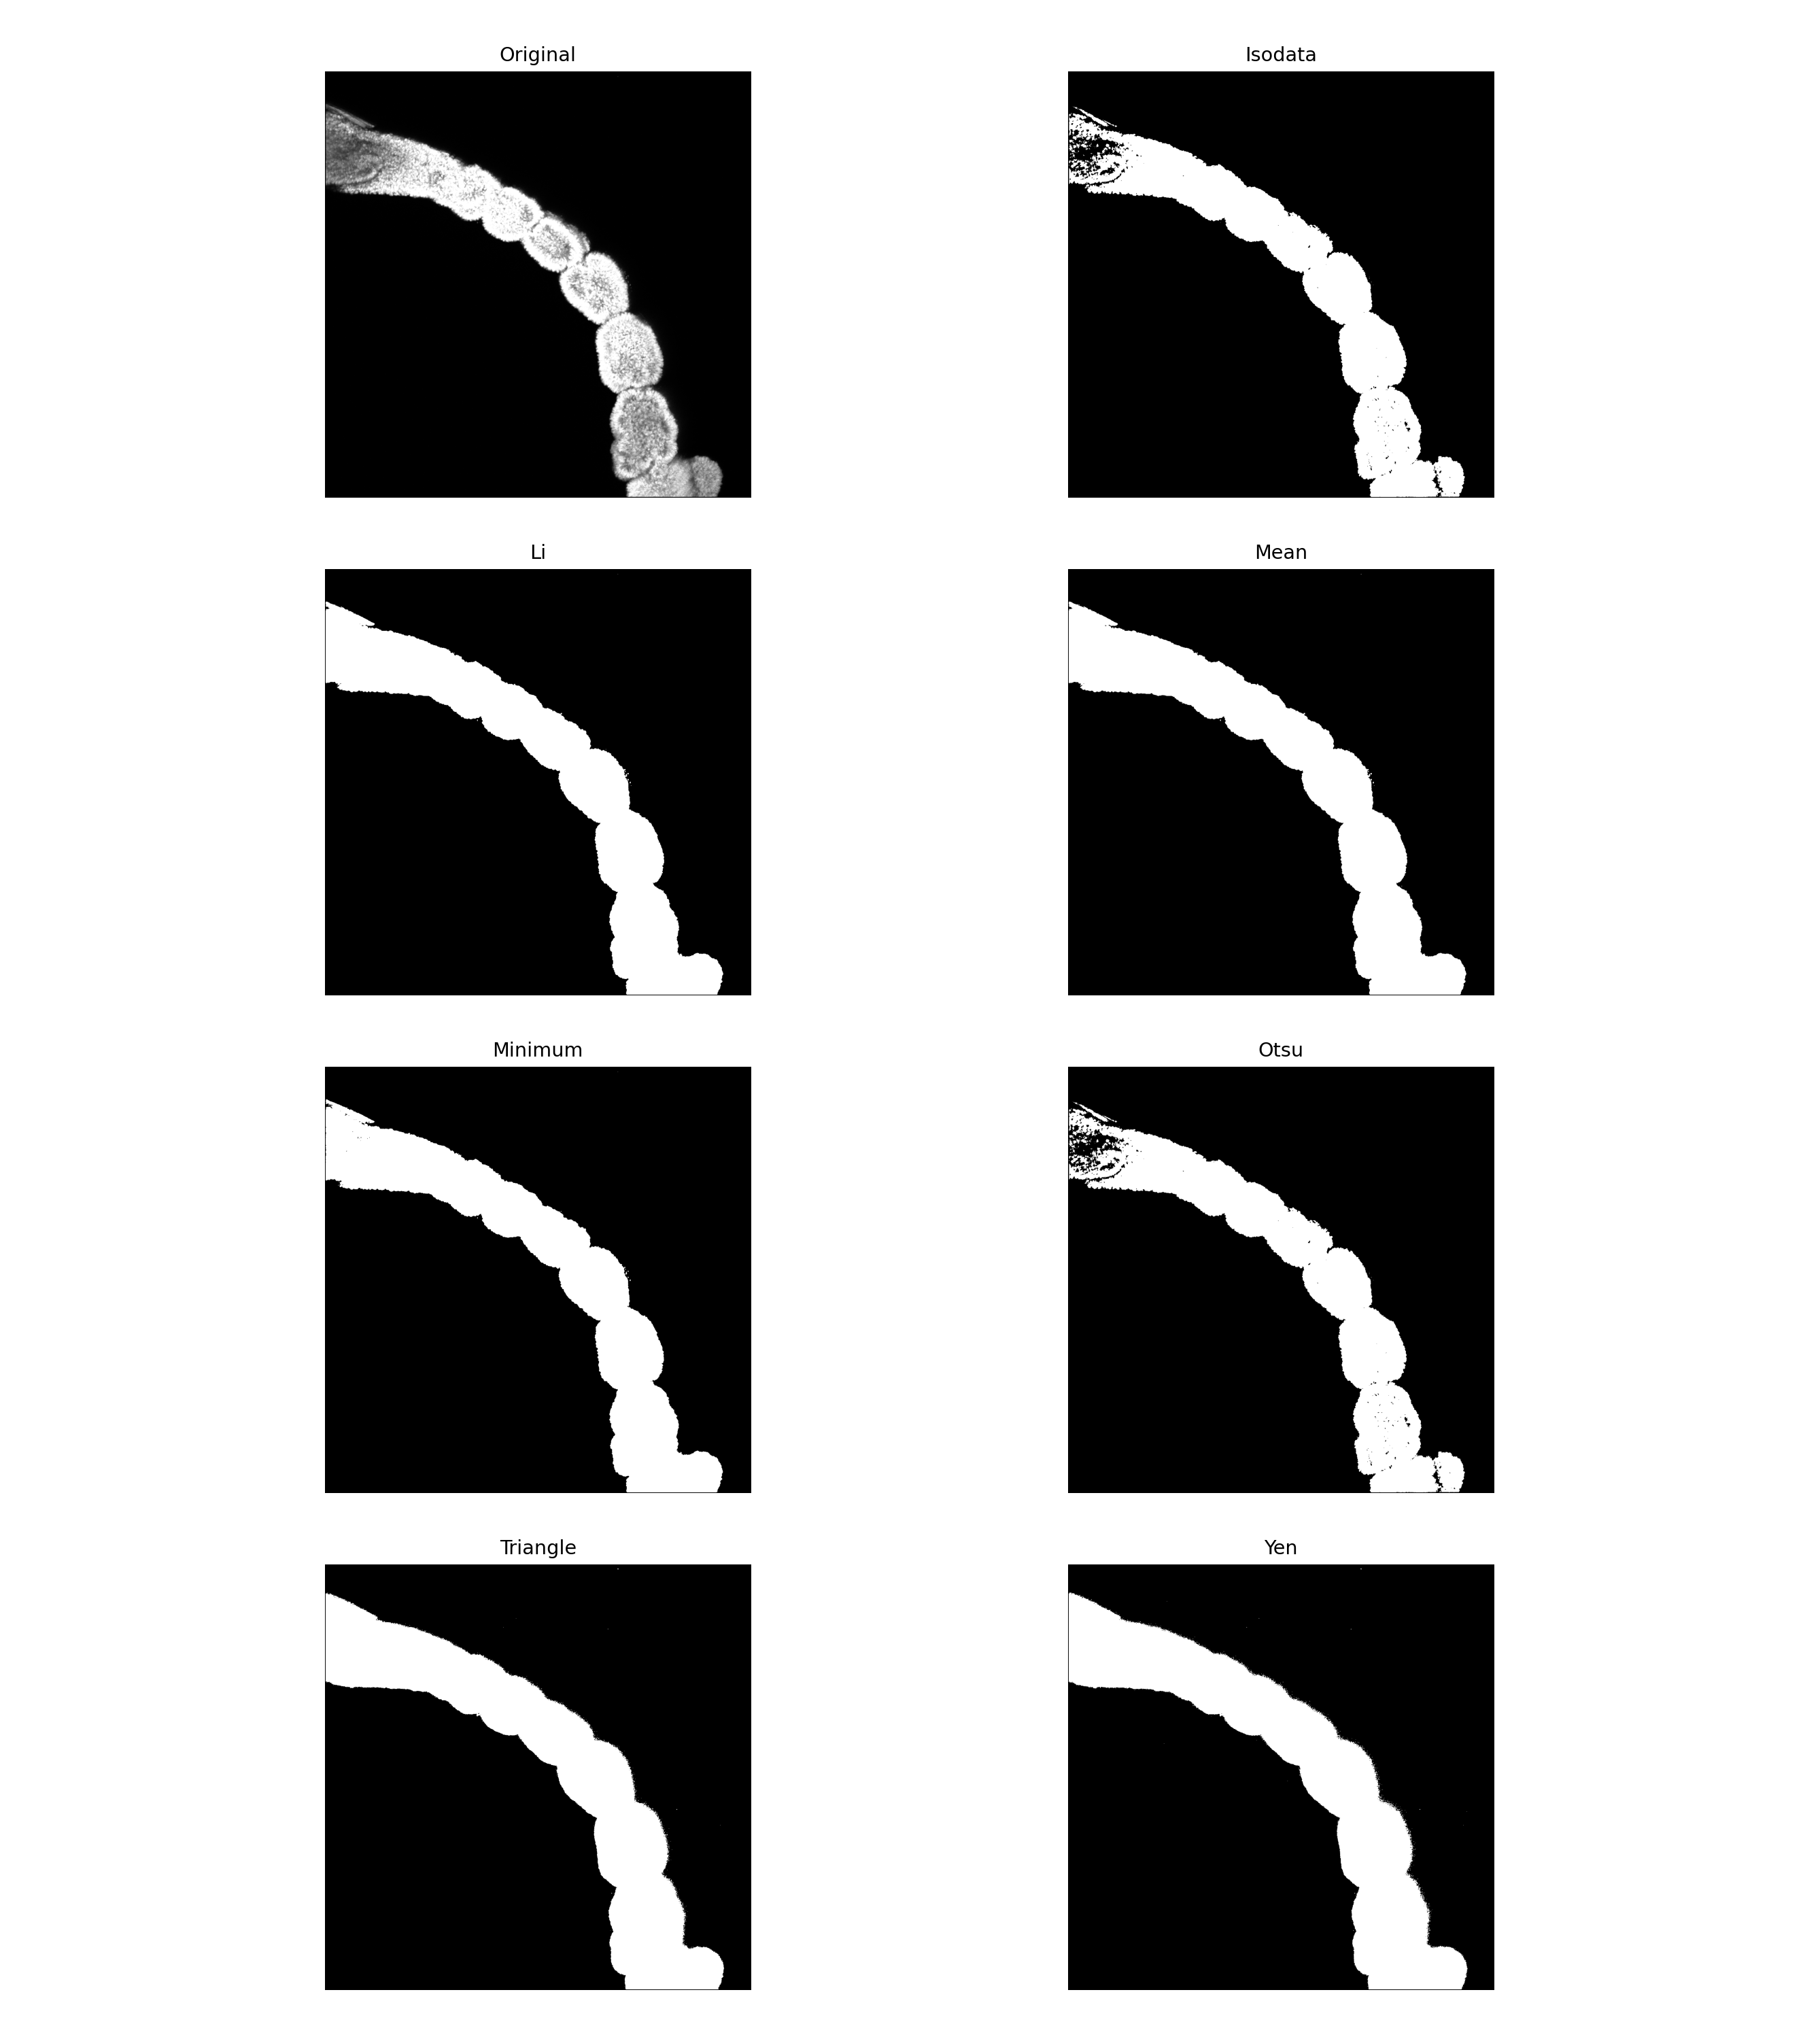

In [3]:
### select image file
app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
fname = QtWidgets.QFileDialog.getOpenFileName(None, "Select a file...", '.', filter="All files (*)")[0]
print('Chosen file:', fname)
    
### load image
img = imread(fname)
img = np.pad(img,10,constant_values=200)
print('Image size:', img.shape)

folder = os.path.split(fname)[0]
filename = os.path.split(fname)[1]
f = os.path.join(folder, 'pixel_size.xlsx')
df = pd.read_excel(f)
pxl_size = df[df.filename==filename].pixel_size.values[0]

print('Pixel size (um/pxl):', float(pxl_size))

### rescale to homogeneous pixel size of 1um/pixel
new_shape = [int(img.shape[0]*pxl_size), int(img.shape[1]*pxl_size)]
img = resize(img, new_shape,
                       anti_aliasing=True)
print('New image size:', img.shape)

### choose best thresholding algorithm

fig, ax = filters.try_all_threshold(img[10:-10,10:-10], figsize=(9, 10), verbose=False)

<IPython.core.display.Javascript object>


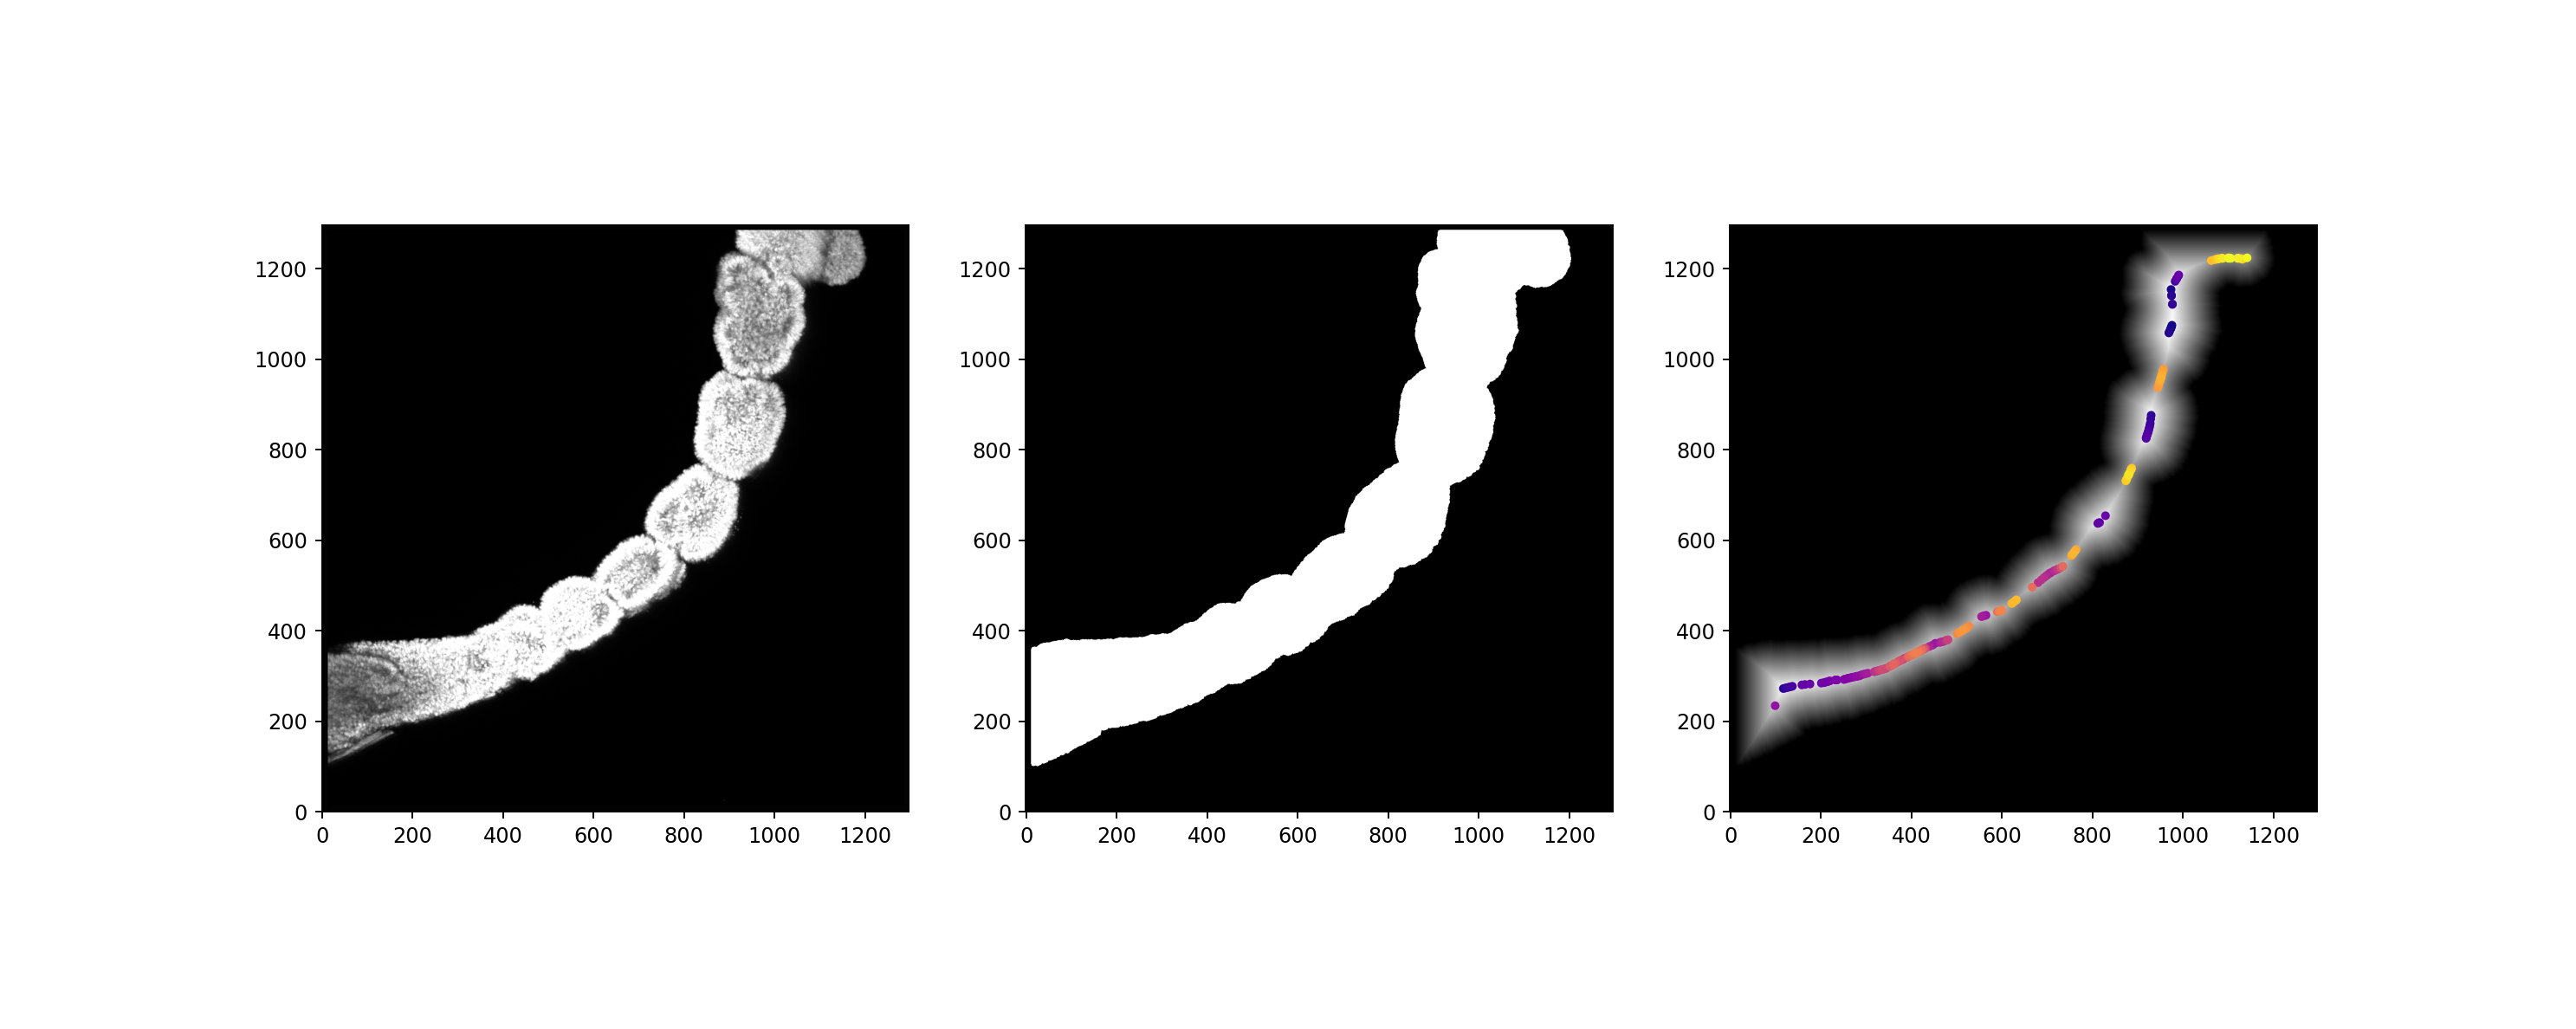

In [4]:
thr_type = 'triangle'
max_hole = 100000
min_object = 100000
disk_size = 5

###
if thr_type == 'isodata':
    filter_fun = filters.threshold_isodata
if thr_type == 'li':
    filter_fun = filters.threshold_li
if thr_type == 'mean':
    filter_fun = filters.threshold_mean
if thr_type == 'minimum':
    filter_fun = filters.threshold_minimum
if thr_type == 'otsu':
    filter_fun = filters.threshold_otsu
if thr_type == 'triangle':
    filter_fun = filters.threshold_triangle
if thr_type == 'yen':
    filter_fun = filters.threshold_yen

thr = filter_fun(img[10:-10,10:-10])
mask = img>thr
mask = remove_small_holes(mask,max_hole)
mask = remove_small_objects(mask,min_object)
mask = binary_opening(mask, disk(disk_size))

edt = distance_transform_edt(mask)
cs = peak_local_max(edt)

### visualize
fig, ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(img, cmap='gray', origin='lower')
ax[1].imshow(mask, cmap='gray', origin='lower')
ax[2].imshow(edt, cmap='gray', origin='lower')
ax[2].scatter(cs[:,1],cs[:,0],alpha=1, c=np.arange(len(cs)), cmap='plasma', s=10)


<IPython.core.display.Javascript object>


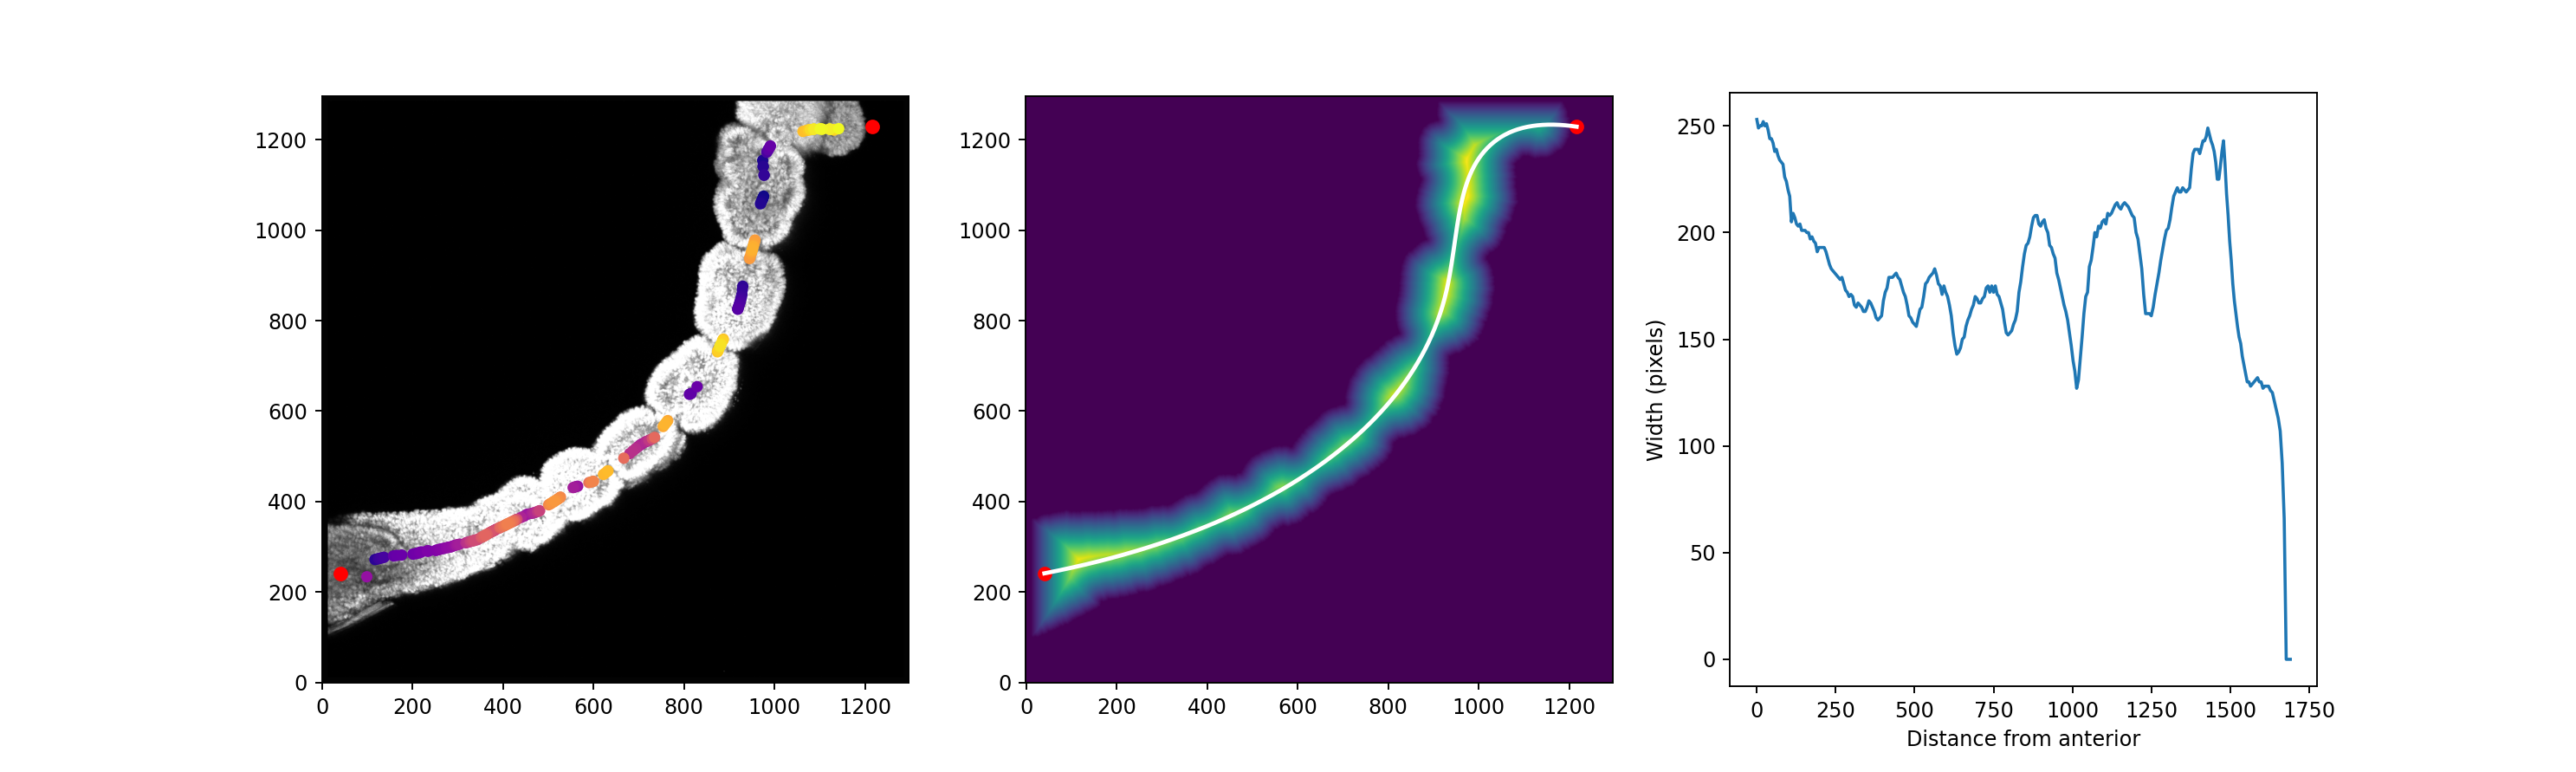

In [5]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

output = {'endpoints':[]} 

landmarks = cs.copy()
cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = ax[0].imshow(img, cmap='gray', origin='lower')
ax[0].scatter(cs[:,1],cs[:,0],alpha=1, c=np.arange(len(cs)), cmap='plasma', s=20)
scatter = ax[0].scatter([], [],color='red') # endpoints scatter

ax[1].imshow(edt, origin='lower')
plot1, = ax[1].plot([],[],'-', color='w', lw=2) # spline (ps)
quiver1 = ax[1].quiver([],[], [], [], color='w', alpha=0.25)
scatter1 = ax[1].scatter([],[],alpha=1,c='red') # endpoints on spline

plot2, = ax[2].plot([],[]) # profile
ax[2].set_xlabel('Distance from anterior')
ax[2].set_ylabel('Width (pixels)')
plt.show()

<IPython.core.display.Javascript object>


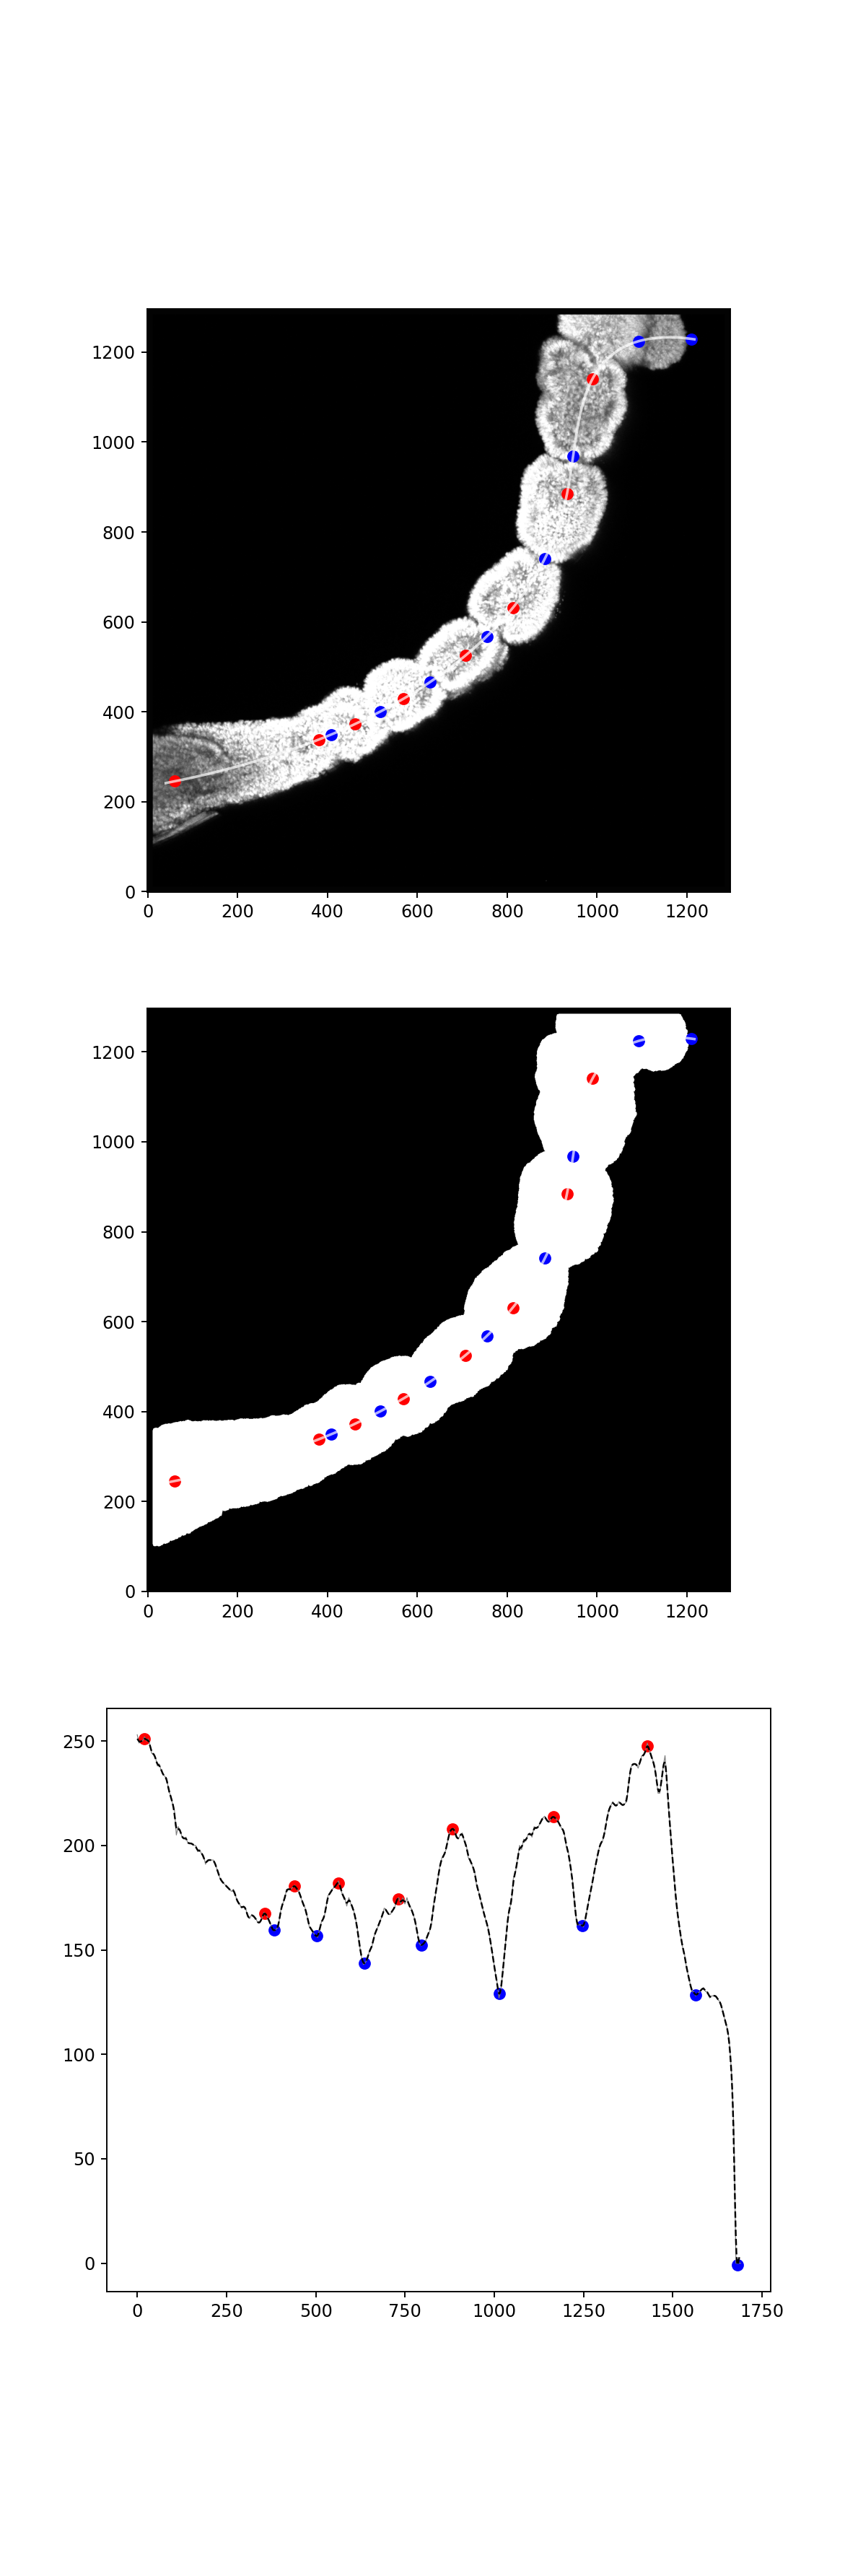

In [6]:
profile = output['profile']
arc_length = output['arc_length']
ps = output['ps']

### inteprolate on homogeneous x axis
x = np.linspace(0, np.max(arc_length), 1000)
f = interpolate.interp1d(arc_length, profile, kind='cubic')
y = f(x)
# smoothen slightly the curve
y = gaussian_filter1d(y, 2)

### find minima and maxima
idxs_min = argrelextrema(y, np.less, order=20)[0]
idxs_max = argrelextrema(y, np.greater, order=20)[0]

xmin = x[idxs_min]
ymin = y[idxs_min]

xmax = x[idxs_max]
ymax = y[idxs_max]

### find idxs on original profile
profile_idxs_min = []
for x1,y1 in zip(xmin,ymin):
    dists = [np.linalg.norm(p-np.array([x1,y1])) for p in np.array([arc_length,profile]).T]
    idx = np.where(dists==np.min(dists))[0][0]
    profile_idxs_min.append(idx)
profile_idxs_max = []
for x1,y1 in zip(xmax,ymax):
    dists = [np.linalg.norm(p-np.array([x1,y1])) for p in np.array([arc_length,profile]).T]
    idx = np.where(dists==np.min(dists))[0][0]
    profile_idxs_max.append(idx)
    
# plot
fig, ax = plt.subplots(3,1, figsize=(4,12))
ax[2].plot(arc_length, profile, '-', color='gray', lw=0.5)
ax[2].plot(x, y, '--k', lw=1)
ax[2].scatter(xmin, ymin, color='blue')
ax[2].scatter(xmax, ymax, color='red')

ax[0].imshow(img, cmap='gray', origin='lower')
ax[0].plot(ps[:,1], ps[:,0], '-w', alpha=.7)
ax[0].scatter(ps[profile_idxs_min,1], ps[profile_idxs_min,0], color='blue')
ax[0].scatter(ps[profile_idxs_max,1], ps[profile_idxs_max,0], color='red')

ax[1].imshow(mask, cmap='gray', origin='lower')
ax[1].plot(ps[:,1], ps[:,0], '-w', alpha=.7)
ax[1].scatter(ps[profile_idxs_min,1], ps[profile_idxs_min,0], color='blue')
ax[1].scatter(ps[profile_idxs_max,1], ps[profile_idxs_max,0], color='red')

In [7]:
a = input('Minimum point: ')
b = input('Maximum point: ')

lims = [int(a),int(b)]

Minimum point: 250
Maximum point: 1250


In [8]:
idxs_min_filt = [i for i in idxs_min if (x[i]>lims[0])and(x[i]<lims[1])]
dx = x[1]-x[0]

vals = []
for i in range(len(idxs_min_filt)-1):
    idx1 = idxs_min_filt[i]
    idx2 = idxs_min_filt[i+1]
    
    x1 = x[idx1]
    x2 = x[idx2]
    
    area = np.sum(dx*y[idx1:idx2])
    length = x2-x1
    width = np.max(y[idx1:idx2])
    print(x1,x2,area,length,width)
    vals.append([area, length, width])
    
vals = np.array(vals)

vals = {'area': vals[:,0],
       'length': vals[:,1],
       'width': vals[:,2]}

384.0255778484029 502.44756220694126 20155.030972113873 118.42198435853834 180.50430189023464
502.44756220694126 636.0952302687202 22569.804537918615 133.64766806177897 182.12704607558624
636.0952302687202 795.1190378359004 26077.220865824762 159.02380756718014 174.42279197952516
795.1190378359004 1015.0455802160429 39326.34379071639 219.92654238014256 207.9331229865216
1015.0455802160429 1246.8143210320395 44504.407739436414 231.76874081599658 213.6628764802408


In [9]:
### save data
outdict = {'midline':output,
           'segmentation_params':{'thr_type': thr_type,
                                    'max_hole': max_hole,
                                    'min_object': min_object,
                                    'disk_size': disk_size},
           'img':img,
           'mask':mask,
           'somite_size':vals,
           'somite_lims':lims}

import pickle, os
filename = os.path.splitext(fname)[0]+'_SomiteSize.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(outdict, handle, protocol=pickle.HIGHEST_PROTOCOL)